In [11]:
# interpolate [co2] from 47 model levels to 20 OCO2 levels

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [13]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re

In [14]:
# month of the simulation
month      = 4     # 1,2,3, 
name_month = 'Apr' # = Jan, Feb, Mar

In [15]:
# Name and path of inputs and outputs
input_directory = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018-0' + str(month) + '/nd51/'
model_file = '2d_ts_satellite.20180' + str(month) + '.nc'
input_file = input_directory + model_file
# corresponding satellite data
satellite_directory = '/geos/u73/msadiq/satellite/oco-2/'
satellite_file = '2d_OCO2_extract_20180' + str(month) + '.nc'

output_file = input_directory + 'interpolated_' + model_file
output_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/'


In [16]:
# model input
ds_model          = xr.open_dataset(input_file)

levels_model      = ds_model['levels']
surf_press_mod    = ds_model['PEDGE_S_PSURF']
profile_press_mod = surf_press_mod * levels_model # pressure at different levels
record            = ds_model['record'].values

In [17]:
# satellite input
ds_satellite = xr.open_dataset(satellite_directory + satellite_file)
levels_sat = ds_satellite['levels']
surf_press_sat = ds_satellite['psurf']       # not really needed
profile_press_sat = ds_satellite['pressure'] # pressure profile of different levels
print(profile_press_sat[47007].values)
# multi_pressure = surf_pressure * levels_sat
# multi_pressure[47007,:].values            # same as pressure profile

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


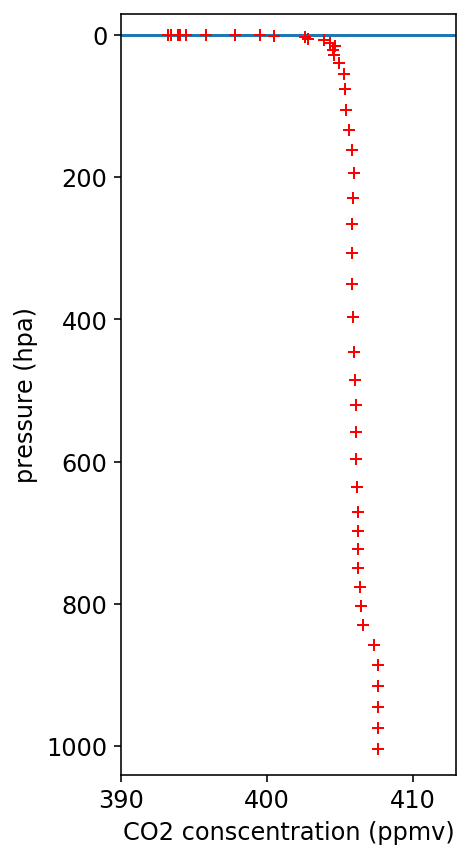

In [18]:
# pick one location where we have data from OCO2 
# and show difference in levels
irecord = 47007
y_press_mod = profile_press_mod[irecord,:].values
y_press_sat = profile_press_sat[irecord].values
x_co2       = ds_model['SpeciesConc_CO2'][47007,:] # 47 levels

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+') # co2 unit is still ppbv here
ax.set_ylim(1040,-30)  # reverse y axis
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure (hpa)')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()

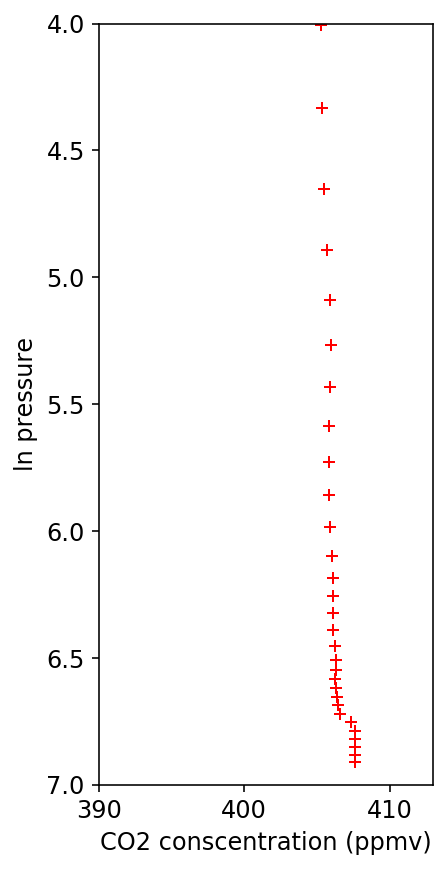

In [19]:
# pick one location where we have data from OCO2
# show in ln pressure coordinate
# linear interpolation using ln(pressure)
# show results of interpolation
y_press_mod = np.log(profile_press_mod[irecord,:].values)
y_press_sat = np.log(profile_press_sat[irecord].values)
x_co2       = ds_model['SpeciesConc_CO2'][irecord,:]

interpolated_co2 = np.interp(x = y_press_sat, xp = np.flip(y_press_mod), fp = np.flip(x_co2)) # linear inte

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+')
ax.plot(interpolated_co2*1e-3, y_press_sat, 'b^')
ax.set_ylim(7,4)
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('ln pressure')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()

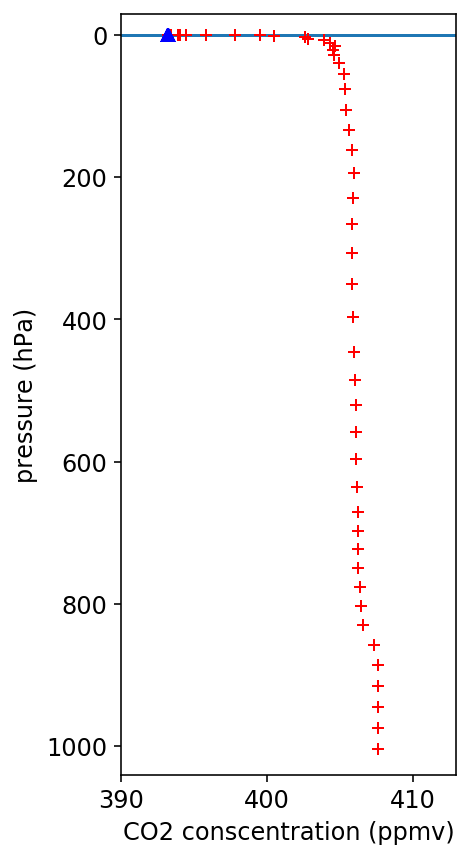

In [20]:
y_press_mod = profile_press_mod[irecord,:].values
y_press_sat = profile_press_sat[irecord].values
x_co2       = ds_model['SpeciesConc_CO2'][irecord,:]

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+')
ax.plot(interpolated_co2*1e-3, y_press_sat, 'b^')
ax.set_ylim(1040,-30)
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure (hPa)')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()
#fig.savefig(output_directory + 'interpolation.png', bbox_inches='tight')

In [21]:
# new dataset to store interpolated co2 from model
interpolated = ds_satellite['pressure'].to_dataset()
interpolated

<xarray.Dataset>
Dimensions:   (levels: 20, record: 393120)
Coordinates:
  * record    (record) int64 0 1 2 3 4 5 ... 393115 393116 393117 393118 393119
  * levels    (levels) float32 1e-04 0.05263158 0.10526316 ... 0.94736844 1.0
Data variables:
    pressure  (record, levels) float32 ...

In [22]:
varnames = list(ds_model.keys())  # Get a list of variable names. The expression is a bit cumbersome. Just copy and paste it for now.
nvar = len(varnames)  # how many elements in the list?
needed_vars = np.append(varnames[0], varnames[7:29])

In [23]:
# temporary 2d dataarray to save interpolated data
tmp = xr.DataArray(data = 0,
                   dims=('record', 'levels'),
                   coords=[record, ds_satellite.coords['levels']])
tmp = tmp.astype(dtype = 'float32')
tmp

<xarray.DataArray (record: 393120, levels: 20)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 393115 393116 393117 393118 393119
  * levels   (levels) float32 1e-04 0.05263158 0.10526316 ... 0.94736844 1.0

In [24]:
for ivar in needed_vars:
    interpolated[ivar] = tmp.copy()
interpolated

<xarray.Dataset>
Dimensions:               (levels: 20, record: 393120)
Coordinates:
  * record                (record) int64 0 1 2 3 ... 393116 393117 393118 393119
  * levels                (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    pressure              (record, levels) float32 ...
    SpeciesConc_CO2       (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag1   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag2   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag3   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag4   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag5   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag6   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag7   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag8   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag9   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag10  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag11  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag12  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag13  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag14  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag15  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag16  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag17  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag18  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag19  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag20  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag21  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag22  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [25]:
# interpolation
for irecord in record:
    if profile_press_sat[irecord][19] != 0.:   # if measurement is non-zero, i.e. exists
        for ivar in needed_vars:
            before         = ds_model[ivar] # get co2 before interpolation
            x_co2          = before[irecord,:].values # a co2 profile
            pres_before    = np.log(profile_press_mod[irecord].values)
            pres_after     = np.log(profile_press_sat[irecord])
            # linear interpolation            
            interpolated[ivar][irecord,:] = np.interp(x  = pres_after, 
                                                      xp = np.flip(pres_before), # increasing order
                                                      fp = np.flip(x_co2)) 
        print(irecord)

2208
2352
2495
2496
2604
2619
2639
2753
2892
2897
2986
3041
3051
3090
3130
3179
3185
3214
3254
3323
3328
3358
3457
3467
3472
3502
3541
3542
3610
3611
3616
3646
3666
3705
3744
3754
3760
3790
3809
3888
3898
3904
3933
3953
3973
4012
4042
4047
4048
4057
4117
4136
4137
4156
4186
4191
4201
4241
4261
4280
4300
4345
4385
4404
4424
4444
4489
4548
4568
4588
4623
4633
4652
4653
4672
4712
4731
4732
4767
4776
4777
4796
4816
4856
4875
4910
4920
4940
4960
4980
4999
5019
5054
5064
5084
5104
5123
5143
5163
5192
5193
5198
5208
5228
5238
5247
5267
5287
5307
5336
5342
5352
5372
5382
5391
5411
5431
5451
5480
5486
5496
5515
5535
5555
5575
5624
5630
5639
5640
5679
5718
5719
5768
5773
5783
5823
5862
5912
5917
5927
5967
6006
6026
6055
6056
6061
6071
6111
6130
6170
6199
6205
6215
6254
6294
6314
6343
6349
6359
6389
6398
6438
6457
6458
6477
6487
6492
6493
6502
6542
6601
6621
6631
6636
6646
6745
6765
6775
6780
6790
6889
6909
6918
6919
6924
6934
6973
7013
7033
7053
7062
7068
7078
7117
7148
7157
7177
7206
7222
7241


49678
49763
50038
50182
50468
55097
55137
55241
55444
55469
55633
55692
55712
55731
55732
55777
55836
55856
55875
55920
55980
56019
56064
56123
56124
56143
56163
56267
56287
56307
56332
56352
56431
56450
56476
56496
56575
56594
56610
56620
56679
56718
56719
56754
56763
56764
56803
56823
56843
56862
56907
56927
56947
56967
56986
57006
57051
57091
57110
57130
57150
57234
57235
57254
57274
57294
57339
57378
57398
57418
57438
57457
57522
57542
57562
57581
57582
57601
57626
57646
57666
57686
57706
57725
57745
57760
57770
57810
57830
57869
57889
57904
57914
57954
57973
58013
58048
58058
58097
58098
58117
58137
58176
58192
58202
58241
58261
58301
58320
58336
58346
58385
58405
58464
58479
58480
58489
58549
58579
58623
58633
58767
58777
58817
58856
58911
58921
59020
59055
59065
59164
59199
59209
59342
59343
59352
59451
59486
59496
59575
59595
59630
59640
59719
59739
59774
59784
59843
59854
59863
59883
59918
59928
59947
59948
59987
60007
60027
60046
60056
60061
60062
60072
60082
60091
60131
6014

109856
109866
109891
109901
109931
109941
109951
109960
109980
109991
110000
110019
110020
110035
110045
110074
110075
110084
110085
110124
110144
110179
110218
110228
110268
110297
110323
110333
110362
110372
110412
110431
110451
110466
110467
110476
110506
110516
110555
110556
110595
110610
110620
110650
110660
110699
110729
110739
110754
110764
110804
110873
110898
110908
110947
110948
111017
111042
111052
111091
111160
111186
111195
111196
111235
111275
111304
111314
111329
111330
111339
111399
111448
111458
111473
111483
111543
111582
111592
111617
111627
111686
111726
111736
111745
111761
111771
111810
111830
111850
111870
111889
111905
111974
111994
112049
112078
112088
112118
112138
112157
112167
112177
112192
112193
112202
112222
112281
112282
112301
112311
112321
112336
112346
112366
112405
112406
112455
112465
112480
112490
112510
112520
112549
112589
112599
112608
112609
112624
112634
112653
112654
112663
112684
112693
112742
112743
112768
112777
112778
112788
112797
112807

153603
153747
153758
153801
153822
153823
153882
153890
153891
153901
153902
154025
154026
154034
154045
154089
154178
154189
154227
154232
154333
154425
154569
154600
154628
154712
154713
154887
154999
155093
155306
155895
160018
160162
160450
160594
160693
160738
160748
160749
160797
160836
160892
160901
160921
160980
161036
161045
161055
161065
161149
161169
161199
161208
161209
161293
161313
161323
161324
161342
161352
161421
161437
161447
161457
161467
161486
161496
161546
161555
161556
161565
161581
161600
161630
161640
161690
161699
161709
161724
161734
161774
161784
161834
161843
161853
161868
161878
161888
161908
161918
161928
161947
161967
161978
161997
162012
162022
162032
162052
162061
162062
162071
162082
162091
162111
162122
162141
162156
162166
162176
162195
162196
162205
162215
162226
162255
162265
162266
162285
162294
162300
162310
162319
162320
162339
162349
162359
162370
162399
162409
162438
162444
162463
162493
162503
162514
162542
162543
162553
162572
162582
162597

204163
204172
204192
204207
204217
204237
204257
204296
204316
204326
204361
204372
204381
204401
204440
204460
204470
204495
204505
204525
204544
204555
204564
204584
204604
204614
204639
204649
204668
204669
204688
204699
204708
204728
204748
204757
204783
204792
204812
204832
204843
204852
204901
204926
204936
204956
204976
204987
205026
205045
205120
205170
205189
205224
205235
205263
205294
205314
205323
205333
205368
205378
205407
205418
205438
205457
205458
205477
205511
205522
205551
205562
205601
205630
205655
205666
205706
205745
205799
205810
205819
205839
205889
205953
205954
205962
206032
206033
206041
206086
206097
206176
206185
206195
206220
206230
206241
206300
206309
206339
206364
206385
206453
206482
206528
206588
206596
206626
206651
206661
206672
206700
206731
206740
206751
206804
206805
206875
206895
206938
206948
206987
207019
207066
207081
207082
207162
207190
207210
207225
207353
207354
207497
207640
207724
212764
212833
212849
212977
212992
213091
213121
213131

252152
252157
252188
252189
252197
252236
252237
252296
252301
252332
252341
252380
252430
252445
252476
252485
252524
252583
252589
252620
252628
252629
252668
252707
252708
252718
252727
252733
252763
252764
252772
252832
252851
252861
252876
252877
252896
252907
252916
252995
253005
253020
253040
253070
253080
253139
253149
253164
253174
253184
253223
253234
253263
253274
253283
253293
253302
253308
253318
253328
253348
253357
253378
253387
253407
253418
253427
253436
253437
253452
253462
253472
253491
253501
253522
253531
253551
253561
253562
253570
253571
253580
253596
253605
253606
253615
253616
253635
253655
253666
253675
253695
253705
253714
253724
253734
253739
253749
253759
253779
253789
253799
253809
253810
253819
253838
253849
253858
253868
253883
253893
253903
253933
253943
253953
253962
253982
253993
254002
254012
254027
254037
254047
254077
254086
254087
254097
254106
254126
254137
254146
254156
254171
254181
254191
254220
254230
254241
254250
254270
254290
254299
254300

293778
293787
293837
293838
293847
293886
293906
293921
293971
293981
294030
294050
294065
294075
294115
294154
294174
294193
294194
294209
294219
294258
294318
294337
294353
294363
294393
294402
294462
294506
294507
294546
294566
294625
294640
294650
294690
294710
294769
294784
294794
294853
294854
294928
294938
294997
295017
295047
295056
295072
295082
295141
295161
295181
295216
295226
295305
295334
295370
295448
295449
295468
295612
295756
295791
295840
295841
295880
295900
295910
295935
295964
295965
295995
296024
296044
296054
296099
296108
296128
296139
296158
296168
296178
296187
296188
296197
296222
296223
296252
296272
296302
296311
296312
296331
296341
296366
296396
296416
296426
296455
296466
296475
296485
296510
296540
296559
296560
296570
296599
296610
296619
296629
296638
296654
296683
296684
296703
296714
296743
296754
296772
296782
296798
296827
296847
296887
296916
296926
296962
296991
297011
297030
297060
297070
297135
297154
297174
297204
297278
297298
297318
297347

339046
339047
343916
344023
344060
344203
344311
344336
344366
344454
344455
344509
344510
344598
344653
344683
344723
344742
344748
344818
344827
344847
344866
344886
344891
344892
344901
344911
344941
344962
344971
345010
345030
345035
345055
345085
345095
345105
345106
345114
345115
345134
345154
345174
345189
345229
345239
345258
345278
345298
345317
345333
345343
345382
345393
345402
345422
345461
345477
345487
345516
345526
345537
345546
345566
345595
345621
345630
345631
345660
345681
345690
345710
345720
345729
345739
345749
345764
345774
345804
345814
345824
345825
345834
345853
345864
345873
345883
345893
345908
345918
345948
345958
345968
345977
345978
346017
346027
346052
346062
346082
346092
346101
346112
346121
346141
346161
346171
346180
346181
346186
346196
346206
346235
346236
346245
346256
346265
346315
346324
346330
346340
346350
346389
346400
346409
346474
346484
346493
346494
346523
346533
346544
346553
346592
346612
346618
346627
346637
346667
346677
346697
346756

In [26]:
# variables need not to be interpolated
noneed_interp = ['lat', 'lon', 'date']
for ivar in noneed_interp:
    interpolated[ivar] = ds_model[ivar].copy()

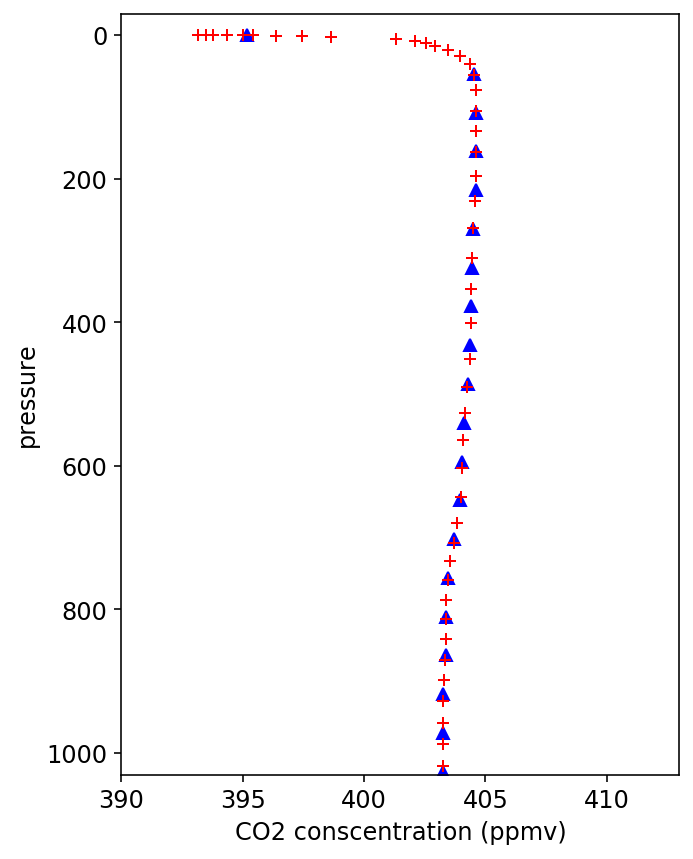

In [30]:
# after interpolation
irecord = 3254
x_co2_after    = interpolated['SpeciesConc_CO2'][irecord,:]
y_press_after  = interpolated['pressure'][irecord,:]

x_co2_before   = ds_model['SpeciesConc_CO2'][irecord,:]
y_press_before = profile_press_mod[irecord]

fig, ax = plt.subplots(figsize=[5,7])

ax.plot(x_co2_after*1e-3, y_press_after, 'b^')
ax.plot(x_co2_before*1e-3, y_press_before, 'r+')
ax.set_ylim(1030,-30)
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure')

plt.show()

In [28]:
interpolated.attrs['comment'] = 'interpolated from 47 level model outputs'
interpolated.to_netcdf(output_file)

In [29]:
interpolated

<xarray.Dataset>
Dimensions:               (levels: 20, record: 393120)
Coordinates:
  * record                (record) int64 0 1 2 3 ... 393116 393117 393118 393119
  * levels                (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    pressure              (record, levels) float32 ...
    SpeciesConc_CO2       (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag1   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag2   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag3   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag4   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag5   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag6   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag7   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag8   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag9   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag10  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag11  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag12  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag13  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag14  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag15  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag16  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag17  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag18  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag19  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag20  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag21  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag22  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lat                   (record) float64 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon                   (record) float64 -180.0 -177.5 -175.0 ... 175.0 177.5
    date                  (record) datetime64[ns] 2018-04-01 ... 2018-04-30
Attributes:
    comment:  interpolated from 47 level model outputs